In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerPerceptron
from models import KerasSimpleRNN, KerasGRU
from sklearn import metrics

Using TensorFlow backend.


Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


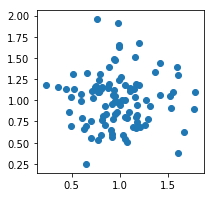

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

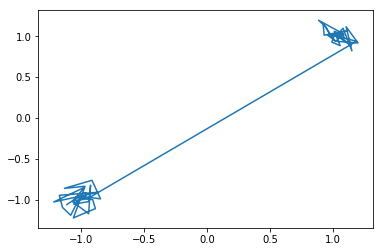

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 1.0  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


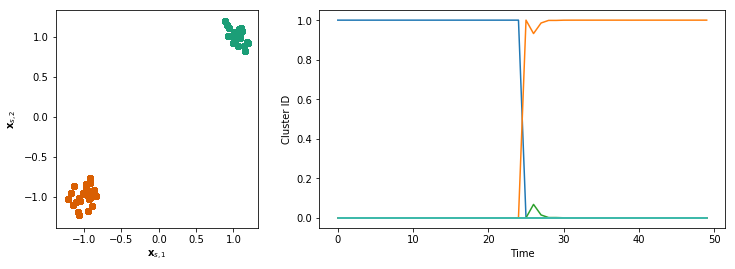

In [6]:
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.8275406327020376
Adjusted Rand Score: 0.924751285304133

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


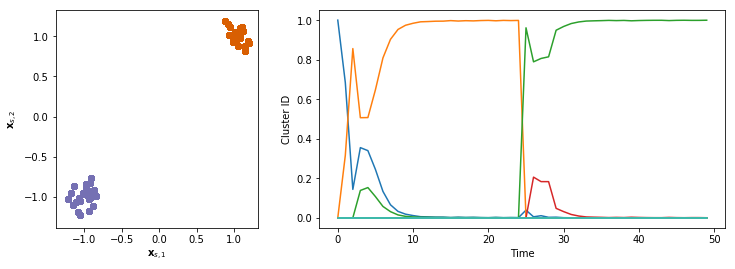

In [11]:
# test case
from models import KerasLDS_b
# Initialize keras model
sem_kwargs2 = dict(lmda=lmda, alfa=alfa, beta=beta*3, 
                  f_class=KerasLDS_b, f_opts=dict(n_epochs=100))

sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)


Adjusted Mutual Information: 0.8884438864742173
Adjusted Rand Score: 0.9607686148919136

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


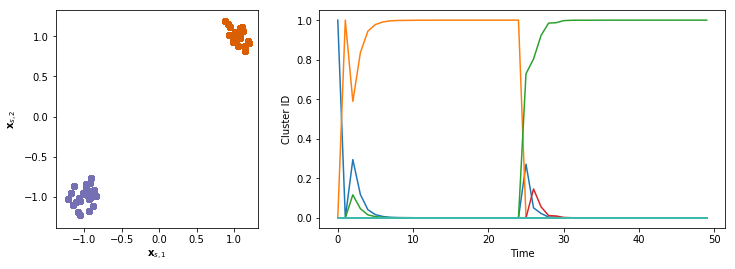

In [12]:
# Initialize keras model
sem_kwargs2a = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2a = SEM(**sem_kwargs2a)
post = sem2a.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer Perceptron


Adjusted Mutual Information: 0.681919088269411
Adjusted Rand Score: 0.7768550763461023

[0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


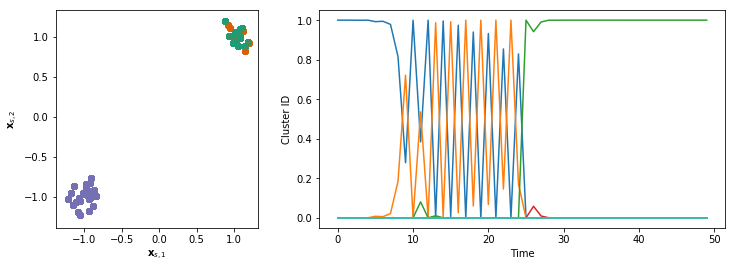

In [13]:
# Initialize keras model
sem_kwargs3 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerPerceptron, f_opts=dict())

sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer Perceptron 


Adjusted Mutual Information: 0.8884438864742173
Adjusted Rand Score: 0.9607686148919136

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


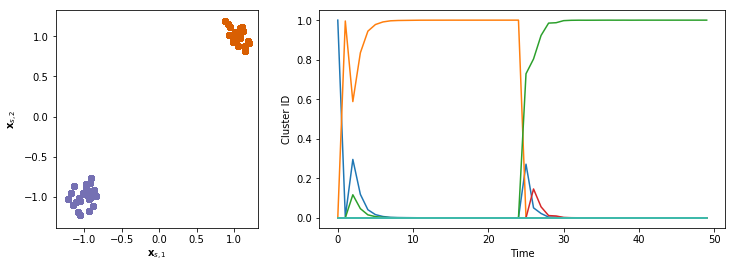

In [14]:
# Initialize keras model
sem_kwargs4 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasSimpleRNN, f_opts=dict(t=2))

sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Units


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


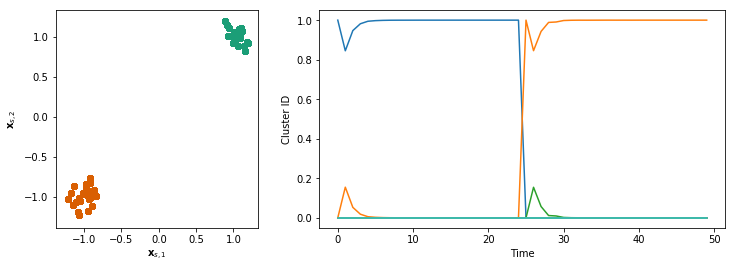

In [15]:
# Initialize keras model
sem_kwargs5 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasGRU, f_opts=dict(t=2))

sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Alternating between 2 static events


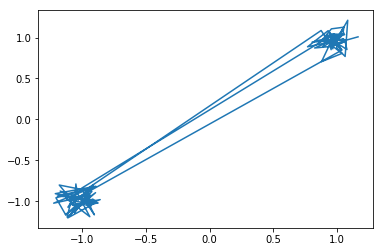

In [23]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


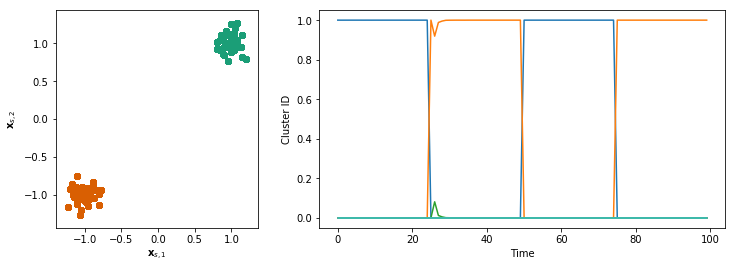

In [17]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.6675185376624759
Adjusted Rand Score: 0.753301062641423

[0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


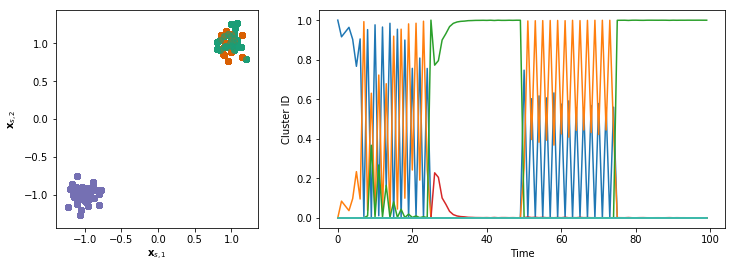

In [18]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Linear Dynamical System (Keras + Estimate Covariance)


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.9801960392078416

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


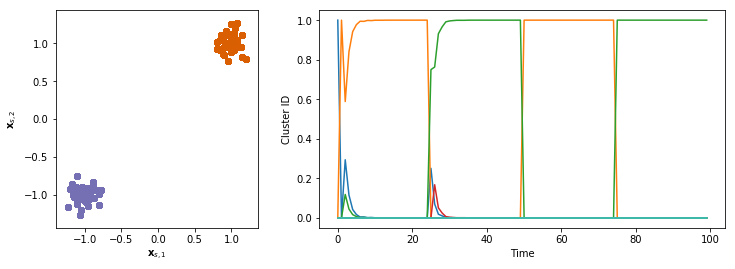

In [19]:
sem2a = SEM(**sem_kwargs2a)
post = sem2a.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


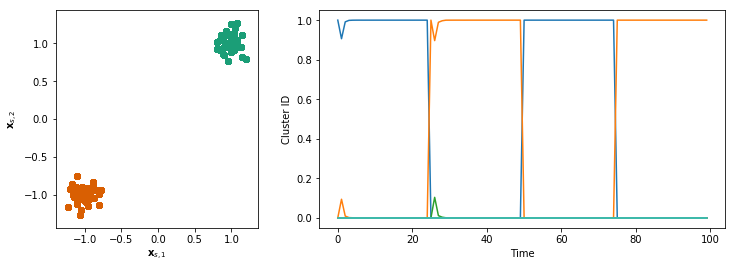

In [20]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


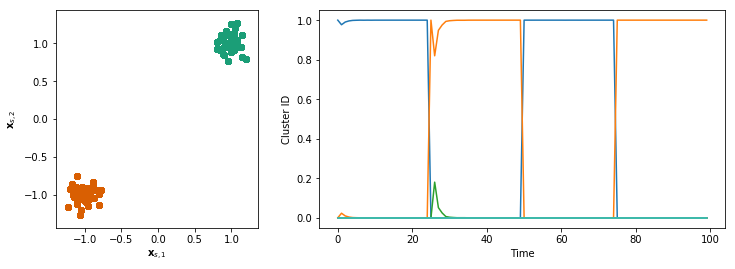

In [21]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Units


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


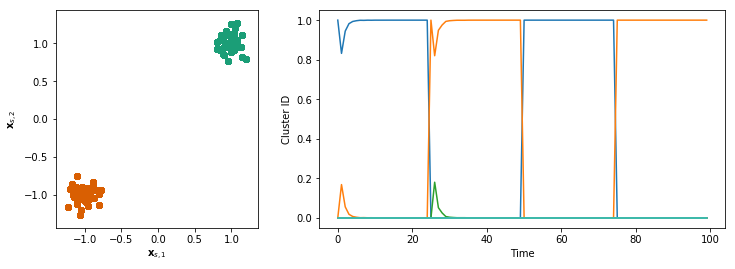

In [22]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

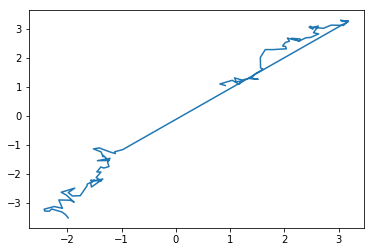

In [24]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


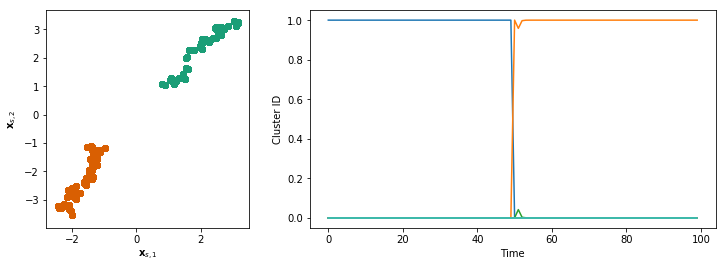

In [25]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.9801960392078416

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


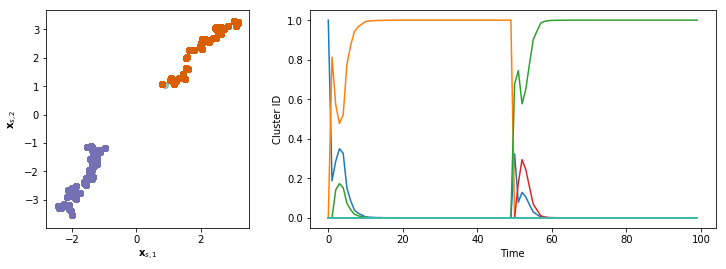

In [26]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Linear Dynamical System (Keras + Estimate Covariance)


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.9801960392078416

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


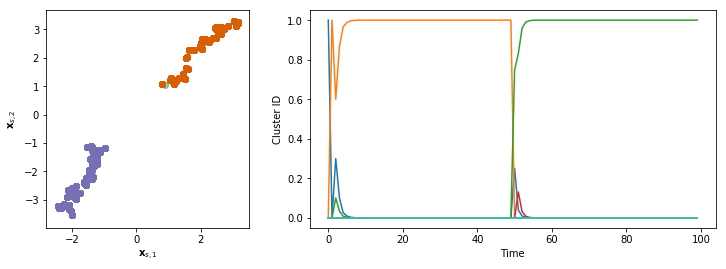

In [27]:
sem2a = SEM(**sem_kwargs2a)
post = sem2a.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


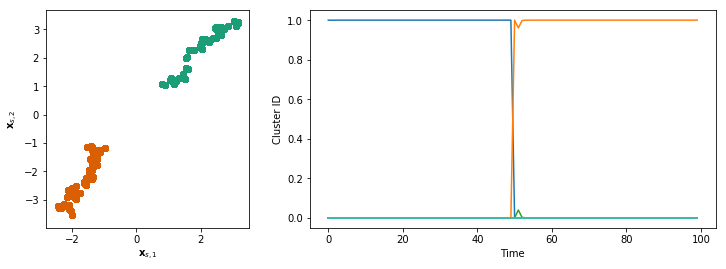

In [28]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.9801960392078416

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


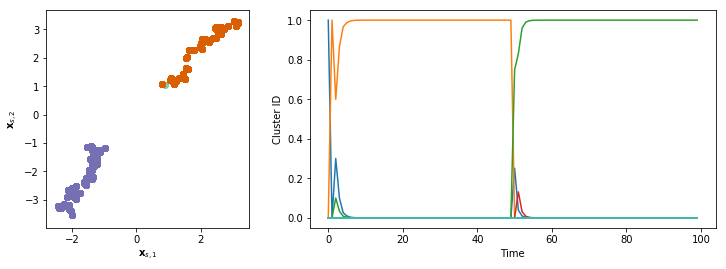

In [29]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Units


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.9801960392078416

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


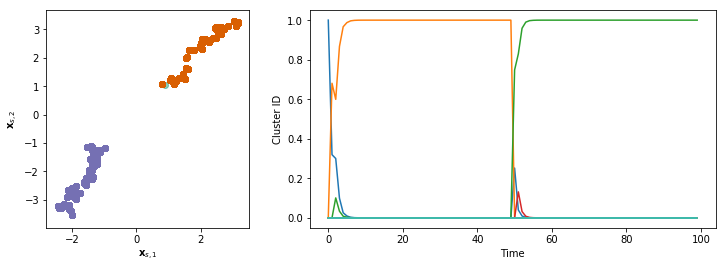

In [30]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Two alternating events with different levels of noise (10x)

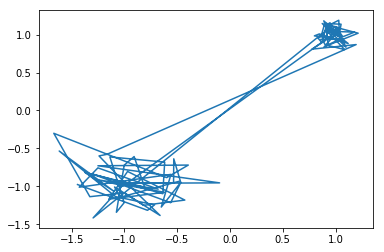

In [39]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.array([beta, beta * 10.])
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Dynamical System (Keras Estimate)


Adjusted Mutual Information: 0.680569300129839
Adjusted Rand Score: 0.7727899394122868

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


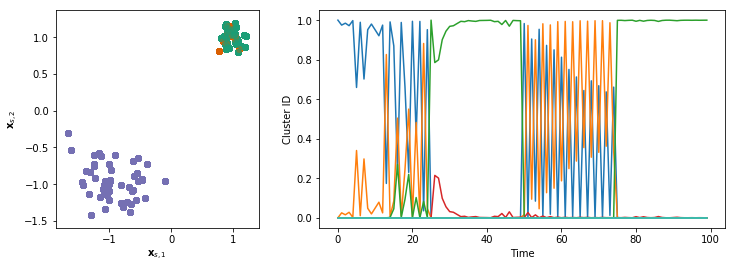

In [41]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Linear dynamical system (Keras + Covariance Estimate)


Adjusted Mutual Information: 0.9328598170547434
Adjusted Rand Score: 0.9801960392078416

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


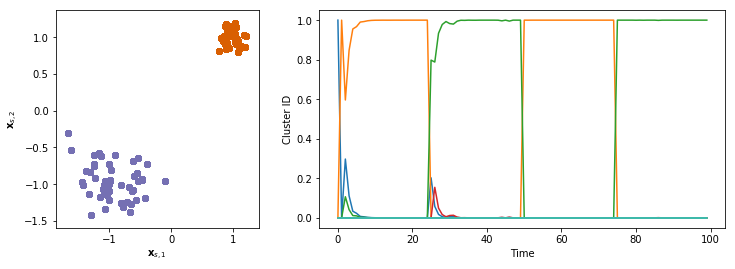

In [40]:
sem2a = SEM(**sem_kwargs2a)
post = sem2a.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


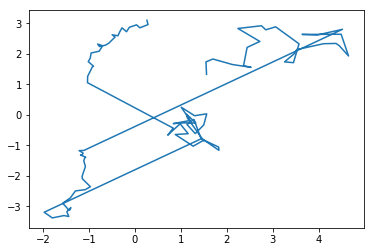

In [56]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigmas = [np.eye(2) * beta* 10.,
            np.eye(2) * beta ,
            np.eye(2) * beta * 10.,
            np.eye(2) * beta ]
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigmas[0])
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[0])
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigmas[1])
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[1])
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigmas[2])
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[2])
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigmas[3])
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[3])      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


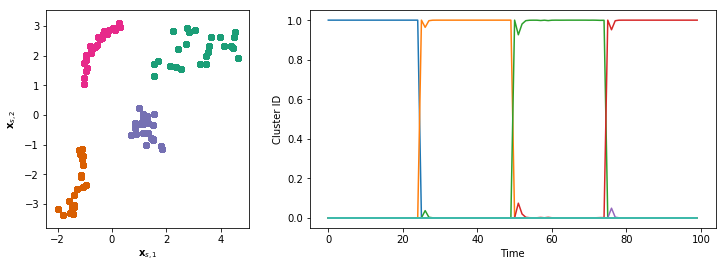

In [57]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.5820714199092074
Adjusted Rand Score: 0.529446380879091

[ 0  0  0  0  0  0  0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8
  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10  9  9  9  9  9  9  9  0  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9]


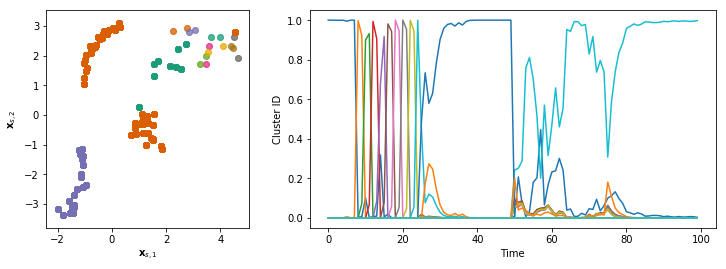

In [58]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)


Adjusted Mutual Information: 0.8057964599952347
Adjusted Rand Score: 0.8179837254434646

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 3 1 1 1 1 0 3 0 3 0 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


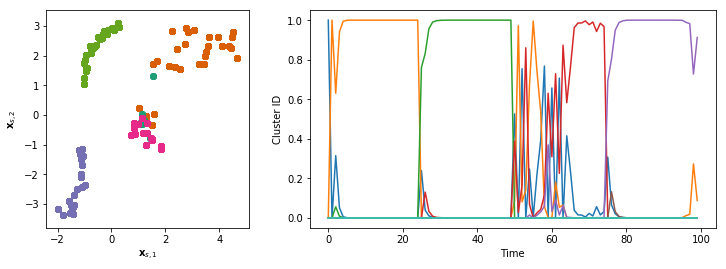

In [59]:
sem2a = SEM(**sem_kwargs2a)
post = sem2a.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.8856039708982999
Adjusted Rand Score: 0.9265743312003035

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 0 3 0 3 0 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


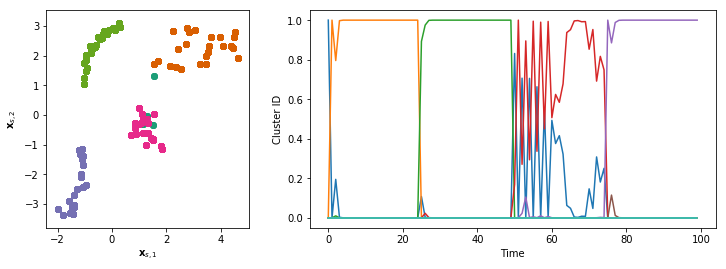

In [60]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.9467614056806593
Adjusted Rand Score: 0.9472597722581074

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


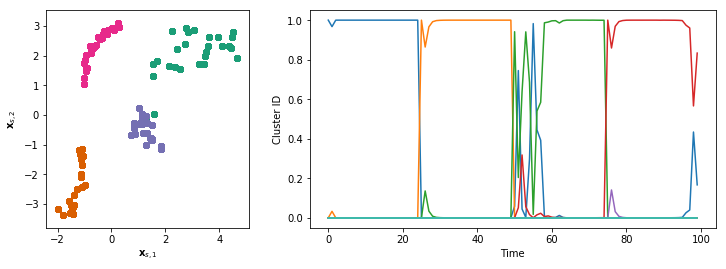

In [61]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Gated Recurrent Units


Adjusted Mutual Information: 0.9467614056806593
Adjusted Rand Score: 0.9472597722581074

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


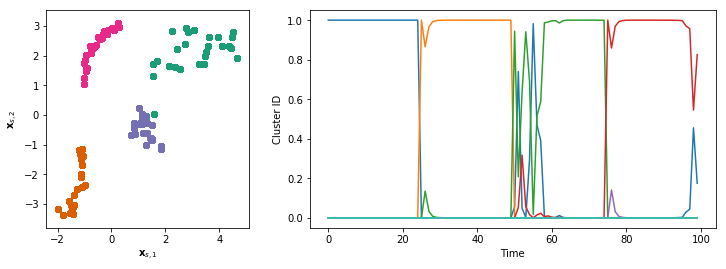

In [62]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)